### Going to add in MS DRG codes, length of stay, patient age (in this dataset, patients over 89 will show as 300+ due to the way records were de-identified), ICD-9 and ICD-10 code

In [1]:
import sqlite3 as sl
import pandas as pd

#connect to sql
conn = sl.connect('../Data/patient_data.db')
c = conn.cursor()

In [2]:
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

ADMISSIONS
CALLOUT
CPTEVENTS
DX_ICD
D_CPT
DRGCODES
ICUSTAY
NOTES
PATIENTS
SERVICES
DRG


### used https://www.aapc.com/icd-10/codes/ converter to get the correct icd10 code.

In [3]:
new_data = pd.read_sql('''
                    SELECT adm.subject_id, 
                          adm.hadm_id,
                          admission_type,
                          admission_location,
                          notes.chartdate,
                          notes.charttime,
                          notes.category,
                          notes.description,
                          notes.text,
                          adm.diagnosis,
                          cast(JulianDay(adm.dischtime) - JulianDay(adm.admittime) as int) as LOS,
                          cast((JulianDay(adm.admittime) - JulianDay(pt.DOB)) / 365  as int) as Age_at_Admission,
                          cast((JulianDay(pt.DOD) - JulianDay(pt.DOB)) / 365 as int) as Age_at_Death,
                          drg.DRG_CODE,
                          drg.DRG_TYPE,
                          drg.DESCRIPTION AS DRG_DESC,
                          drg.DRG_SEVERITY,
                          drg.DRG_MORTALITY,
                          dx.icd9_code,
                          CASE WHEN dx.icd9_code = 53100 THEN 'K25.0'
                               WHEN dx.icd9_code = 5789 THEN 'K92.2'
                               WHEN dx.icd9_code = 4019 THEN 'I16.9'
                               WHEN dx.icd9_code = 42731 THEN 'I48.91'
                               WHEN dx.icd9_code = 431 THEN 'I61.9'
                               else 'other' end as 'icd10_code',
                         pt.gender,
                         pt.dob,
                         pt.dod,
                         pt.dod_hosp,
                         pt.expire_flag
                    FROM admissions as adm
                    JOIN notes on adm.subject_id = notes.subject_id
                         AND adm.hadm_id = notes.hadm_id
                    JOIN drg on drg.subject_id = adm.subject_id and drg.hadm_id = adm.hadm_id
                    JOIN DX_ICD dx on dx.subject_id = adm.subject_id and dx.hadm_id = adm.hadm_id
                    JOIN patients pt on pt.subject_id = adm.subject_id 
                    WHERE dx.icd9_code in ('53100','5789','4019','42731','431')
                    AND drg.drg_type = 'MS'
                    AND notes.category in ('Discharge summary','Physician');
                       ''',conn)
new_data.to_csv('../Data/new_df.csv')
new_data

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMISSION_LOCATION,CHARTDATE,CHARTTIME,CATEGORY,DESCRIPTION,TEXT,DIAGNOSIS,...,DRG_DESC,DRG_SEVERITY,DRG_MORTALITY,ICD9_CODE,icd10_code,GENDER,DOB,DOD,DOD_HOSP,EXPIRE_FLAG
0,5689,157267,EMERGENCY,EMERGENCY ROOM ADMIT,2124-09-28,None,Discharge summary,Report,Admission Date: [**2124-9-18**] ...,EKG CHANGES,...,"ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS...",None,None,4019,I16.9,F,2048-07-14 00:00:00,2125-01-08 00:00:00,2125-01-08 00:00:00,1
1,5689,157267,EMERGENCY,EMERGENCY ROOM ADMIT,2124-09-28,None,Discharge summary,Report,Admission Date: [**2124-9-18**] ...,EKG CHANGES,...,"ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS...",None,None,42731,I48.91,F,2048-07-14 00:00:00,2125-01-08 00:00:00,2125-01-08 00:00:00,1
2,28389,139931,EMERGENCY,EMERGENCY ROOM ADMIT,2152-09-25,None,Discharge summary,Report,Admission Date: [**2152-9-15**] ...,ABDOMINAL PAIN;AORTIC DISSECTION;TELEMETRY,...,MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC,None,None,4019,I16.9,F,2104-11-22 00:00:00,None,None,0
3,16072,198295,EMERGENCY,EMERGENCY ROOM ADMIT,2184-11-24,None,Discharge summary,Report,Admission Date: [**2184-11-19**] ...,ATRIAL FIBRILLATION;RESPIRATORY FAILURE,...,SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,None,None,4019,I16.9,F,2143-11-23 00:00:00,2184-11-24 00:00:00,2184-11-24 00:00:00,1
4,16072,198295,EMERGENCY,EMERGENCY ROOM ADMIT,2184-11-24,None,Discharge summary,Report,Admission Date: [**2184-11-19**] ...,ATRIAL FIBRILLATION;RESPIRATORY FAILURE,...,SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,None,None,42731,I48.91,F,2143-11-23 00:00:00,2184-11-24 00:00:00,2184-11-24 00:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20856,60929,109316,EMERGENCY,CLINIC REFERRAL/PREMATURE,2142-07-04,None,Discharge summary,Report,Admission Date: [**2142-6-29**] ...,SEIZURE,...,ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REHABILIT...,None,None,4019,I16.9,F,2084-06-29 00:00:00,None,None,0
20857,75779,123505,EMERGENCY,CLINIC REFERRAL/PREMATURE,2128-08-27,None,Discharge summary,Report,Admission Date: [**2128-8-6**] D...,CONGESTIVE HEART FAILURE,...,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W ...,None,None,4019,I16.9,M,2055-06-23 00:00:00,None,None,0
20858,75779,123505,EMERGENCY,CLINIC REFERRAL/PREMATURE,2128-08-27,None,Discharge summary,Report,Admission Date: [**2128-8-6**] D...,CONGESTIVE HEART FAILURE,...,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W ...,None,None,42731,I48.91,M,2055-06-23 00:00:00,None,None,0
20859,46449,110075,EMERGENCY,CLINIC REFERRAL/PREMATURE,2174-06-07,None,Discharge summary,Addendum,"Name: [**Known lastname 13679**],[**Known fir...",CHEST PAIN,...,CORONARY BYPASS W CARDIAC CATH W/O MCC,None,None,42731,I48.91,M,2100-02-13 00:00:00,None,None,0


In [4]:
new_data.to_csv('../Data/new_df.csv')

In [5]:
new_data.icd10_code.value_counts()

I16.9     11728
I48.91     7587
I61.9       802
K92.2       722
K25.0        22
Name: icd10_code, dtype: int64

In [6]:
new_data.DRG_CODE.value_counts()

236    926
871    865
64     773
220    773
219    529
      ... 
455      1
503      1
615      1
711      1
708      1
Name: DRG_CODE, Length: 549, dtype: int64

In [7]:
new_data.CATEGORY.value_counts()

Discharge summary    20861
Name: CATEGORY, dtype: int64

In [8]:
md = new_data.loc[(new_data['icd10_code']== 'I61.9') | (new_data['icd10_code']=='K92.2')]
md

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMISSION_LOCATION,CHARTDATE,CHARTTIME,CATEGORY,DESCRIPTION,TEXT,DIAGNOSIS,...,DRG_DESC,DRG_SEVERITY,DRG_MORTALITY,ICD9_CODE,icd10_code,GENDER,DOB,DOD,DOD_HOSP,EXPIRE_FLAG
27,18376,150349,EMERGENCY,EMERGENCY ROOM ADMIT,2148-11-14,None,Discharge summary,Report,Admission Date: [**2148-11-1**] ...,RIGHT LUNG CANCER;WEAKNESS,...,NERVOUS SYSTEM NEOPLASMS W MCC,None,None,431,I61.9,M,2072-12-29 00:00:00,2148-11-14 00:00:00,2148-11-14 00:00:00,1
59,32212,135900,EMERGENCY,EMERGENCY ROOM ADMIT,2158-11-01,None,Discharge summary,Report,Admission Date: [**2158-10-27**] ...,UPPER GASTROINTESTINAL BLEED,...,G.I. HEMORRHAGE W MCC,None,None,5789,K92.2,F,1858-10-27 00:00:00,2158-11-10 00:00:00,2158-11-10 00:00:00,1
69,30746,155603,EMERGENCY,EMERGENCY ROOM ADMIT,2131-08-28,None,Discharge summary,Report,Admission Date: [**2131-8-22**] ...,ALTERED MENTAL STATUS,...,G.I. HEMORRHAGE W MCC,None,None,5789,K92.2,M,2055-03-16 00:00:00,None,None,0
102,24900,153828,EMERGENCY,EMERGENCY ROOM ADMIT,2172-11-01,None,Discharge summary,Report,Admission Date: [**2172-10-28**] ...,LOWER GI BLEED;TELEMETRY,...,OTHER DIGESTIVE SYSTEM O.R. PROCEDURES W MCC,None,None,5789,K92.2,M,2122-06-10 00:00:00,2172-11-01 00:00:00,2172-11-01 00:00:00,1
112,27261,194743,EMERGENCY,EMERGENCY ROOM ADMIT,2170-11-23,None,Discharge summary,Report,Admission Date: [**2170-11-19**] ...,STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK,...,ACUTE ISCHEMIC STROKE W USE OF THROMBOLYTIC AG...,None,None,431,I61.9,F,2092-04-18 00:00:00,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20762,61991,146377,EMERGENCY,CLINIC REFERRAL/PREMATURE,2159-08-11,None,Discharge summary,Report,Admission Date: [**2159-7-31**] ...,INTRACRANIAL HEMORRHAGE,...,INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION...,None,None,431,I61.9,F,2108-06-12 00:00:00,None,None,0
20777,73241,149216,EMERGENCY,CLINIC REFERRAL/PREMATURE,2118-09-07,None,Discharge summary,Report,Admission Date: [**2118-8-14**] ...,HEPATIC ENCEPHALOPATHY,...,"DISORDERS OF LIVER EXCEPT MALIG,CIRR,ALC HEPA ...",None,None,5789,K92.2,M,2054-03-21 00:00:00,2118-09-07 00:00:00,2118-09-07 00:00:00,1
20802,40292,186944,EMERGENCY,CLINIC REFERRAL/PREMATURE,2116-08-31,None,Discharge summary,Report,Admission Date: [**2116-8-28**] ...,LOWER GI BLEED,...,COMPLICATIONS OF TREATMENT W CC,None,None,5789,K92.2,M,2033-12-03 00:00:00,None,None,0
20808,52298,181420,EMERGENCY,CLINIC REFERRAL/PREMATURE,2171-05-17,None,Discharge summary,Report,Admission Date: [**2171-4-16**] ...,HYPERKALEMIA,...,KIDNEY & URETER PROCEDURES FOR NON-NEOPLASM W MCC,None,None,431,I61.9,M,2109-06-02 00:00:00,2171-11-26 00:00:00,2171-11-26 00:00:00,1


In [9]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import unicodedata
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob
import re

# Models
from sklearn.naive_bayes import MultinomialNB

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, make_scorer

# additional viz
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import PIL.ImageOps

#.py file
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
#import src.functions as asp

np.random.seed(42)
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
from nltk.corpus import stopwords
sw = stopwords.words('english')

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def doc_preparer(doc, stop_words=sw):
    '''  
    :param doc: a document from the corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in stop_words]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

X = md.TEXT.astype('str')
y = md.icd10_code.astype('str')

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.25)

token_docs = [doc_preparer(doc, sw) for doc in X_train]
token_docs[0]

'admission date discharge date date birth sex f service medicine allergy topiramate aripiprazole shellfish bee pollen attend first name lf chief complaint am major surgical invasive procedure paracentesis thoracentesis history present illness f history alcoholic hepatitis recent admission date range gi bleed without clear source subsequently develop c diff treat iv flagyl po vanc taper sbp hcap treat vanc cefepime discharge nursing home yesterday transfer back hospital am report ems hospital rehab febrile today pcxr c w pna go svt rate transfer hospital give adenosine verapamil total l n give apap vanc zosyn transfer ed afebrile alter unable answer question labs show wbc stable hct plt electrolytes wnl exception low mg low ca trop inr ct p obtain look toxic megacolon negative however show large new right pleural effusion lead atelectasis near collapse right low lobe also multifocal ill define opacity lul may reflect infectious process also splenomegaly varix signialying portal hyperten

In [11]:
# Validation train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=42)

cv = CountVectorizer(max_df=250,max_features=500)

X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,abnormal,abuse,acid,active,addition,additional,address,afebrile,afib,albumin,...,warfarin,wave,wean,weight,white,wife,woman,wound,yeast,zosyn
8066,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18374,0,0,0,0,0,1,2,0,0,1,...,0,1,0,0,0,1,0,0,0,0
2548,0,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
5399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6334,0,0,0,0,0,0,0,0,2,0,...,0,0,0,3,0,1,0,0,0,0
413,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,2
1272,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0


In [12]:
mnb = MultinomialNB()
mnb.fit(X_t_vec, y_t)
prior_0 = y_t.value_counts()['I61.9']/len(y_t)
prior_1 = y_t.value_counts()['K92.2']/len(y_t)

print(prior_0, prior_1)
print(np.log(prior_1))

0.5390898483080513 0.46091015169194866
-0.774552153696658


In [13]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

y_hat = mnb.predict(X_t_vec)
print(accuracy_score(y_t, y_hat))
print(confusion_matrix(y_t,y_hat))

0.9568261376896149
[[432  30]
 [  7 388]]


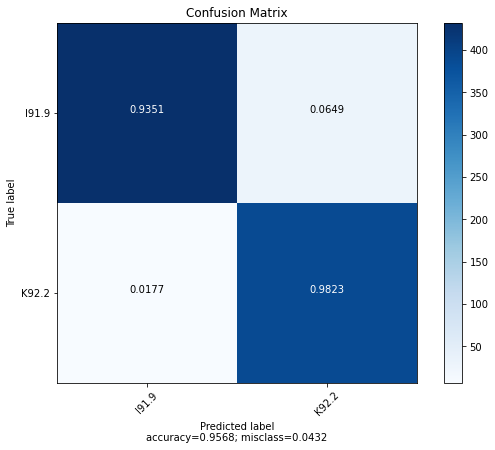

<Figure size 432x288 with 0 Axes>

In [14]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm = np.array(confusion_matrix(y_t,y_hat)), 
                      normalize    = True,
                      target_names = ['I91.9','K92.2'],
                      title        = "Confusion Matrix")
plt.savefig('../Reports/images/ConfMat_ICD10.png') 

In [ ]:
#let's see how it does on the test data.

not bad on the binary classification, let's try adding in a third code


In [15]:
ter = new_data.loc[(new_data['icd10_code']== 'I61.9') | (new_data['icd10_code']=='K92.2') | (new_data['icd10_code'] == 'I48.91')]
ter

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMISSION_LOCATION,CHARTDATE,CHARTTIME,CATEGORY,DESCRIPTION,TEXT,DIAGNOSIS,...,DRG_DESC,DRG_SEVERITY,DRG_MORTALITY,ICD9_CODE,icd10_code,GENDER,DOB,DOD,DOD_HOSP,EXPIRE_FLAG
1,5689,157267,EMERGENCY,EMERGENCY ROOM ADMIT,2124-09-28,None,Discharge summary,Report,Admission Date: [**2124-9-18**] ...,EKG CHANGES,...,"ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS...",None,None,42731,I48.91,F,2048-07-14 00:00:00,2125-01-08 00:00:00,2125-01-08 00:00:00,1
4,16072,198295,EMERGENCY,EMERGENCY ROOM ADMIT,2184-11-24,None,Discharge summary,Report,Admission Date: [**2184-11-19**] ...,ATRIAL FIBRILLATION;RESPIRATORY FAILURE,...,SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,None,None,42731,I48.91,F,2143-11-23 00:00:00,2184-11-24 00:00:00,2184-11-24 00:00:00,1
7,24880,157141,EMERGENCY,EMERGENCY ROOM ADMIT,2118-09-21,None,Discharge summary,Report,Admission Date: [**2118-4-13**] ...,ALTERED MENTAL STATUS,...,OTHER DISORDERS OF NERVOUS SYSTEM W MCC,None,None,42731,I48.91,M,2060-05-23 00:00:00,None,None,0
9,31385,124462,ELECTIVE,PHYS REFERRAL/NORMAL DELI,2146-10-10,None,Discharge summary,Report,Admission Date: [**2146-10-3**] ...,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,...,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W/...,None,None,42731,I48.91,F,2063-02-17 00:00:00,None,None,0
10,19322,169079,ELECTIVE,PHYS REFERRAL/NORMAL DELI,2196-10-21,None,Discharge summary,Report,Admission Date: [**2196-10-12**] ...,LEFT CEREBELLUM TUMOR/SDA,...,MYELOPROLIF DISORD OR POORLY DIFF NEOPL W MAJ ...,None,None,42731,I48.91,M,2131-12-31 00:00:00,2197-03-23 00:00:00,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20850,63187,132488,EMERGENCY,CLINIC REFERRAL/PREMATURE,2150-08-10,None,Discharge summary,Report,Admission Date: [**2150-7-2**] D...,PANCREATITIS,...,EXTENSIVE O.R. PROCEDURE UNRELATED TO PRINCIPA...,None,None,42731,I48.91,M,2097-05-12 00:00:00,None,None,0
20853,73615,172441,ELECTIVE,PHYS REFERRAL/NORMAL DELI,2152-08-30,None,Discharge summary,Report,Admission Date: [**2152-8-23**] ...,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,...,CORONARY BYPASS W/O CARDIAC CATH W/O MCC,None,None,42731,I48.91,M,2087-03-24 00:00:00,None,None,0
20858,75779,123505,EMERGENCY,CLINIC REFERRAL/PREMATURE,2128-08-27,None,Discharge summary,Report,Admission Date: [**2128-8-6**] D...,CONGESTIVE HEART FAILURE,...,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W ...,None,None,42731,I48.91,M,2055-06-23 00:00:00,None,None,0
20859,46449,110075,EMERGENCY,CLINIC REFERRAL/PREMATURE,2174-06-07,None,Discharge summary,Addendum,"Name: [**Known lastname 13679**],[**Known fir...",CHEST PAIN,...,CORONARY BYPASS W CARDIAC CATH W/O MCC,None,None,42731,I48.91,M,2100-02-13 00:00:00,None,None,0


In [16]:
X = ter.TEXT.astype('str')
y = ter.icd10_code.astype('str')

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.25)

token_docs = [doc_preparer(doc, sw) for doc in X_train]
token_docs[0]

'name know lastname know firstname unit numeric identifier admission date discharge date date birth sex service cardiothoracic allergy lipitor lisinopril attend first name lf addendum speak doctor first name dr last name stitle office already assume management mr know lastname last name title vna draw inr today patient already call adjustment discharge disposition home service facility vna location un first name name pattern last name namepattern md md number complete'

In [17]:
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=42)

cv = CountVectorizer(max_df=250,max_features=500)

X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,aaa,aaox,ab,ability,accordingly,acei,acetate,acutely,acyclovir,adenocarcinoma,...,wed,wet,whole,window,withdraw,word,wrist,xrt,yes,yet
10983,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12334,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
16354,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
15704,0,0,0,0,0,0,0,2,0,0,...,0,2,0,0,0,0,0,5,0,0
871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8832,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15902,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
13459,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [18]:
mnb.fit(X_t_vec, y_t)
prior_0 = y_t.value_counts()['I61.9']/len(y_t)
prior_1 = y_t.value_counts()['K92.2']/len(y_t)
prior_2 = y_t.value_counts()['I48.91']/len(y_t)

print(prior_0, prior_1, prior_2)
print(np.log(prior_1))

0.09211553473848556 0.07903981264637003 0.8288446526151444
-2.5378035959100855


In [19]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

y_hat = mnb.predict(X_t_vec)
print(accuracy_score(y_t, y_hat))
print(confusion_matrix(y_t,y_hat))

0.8021077283372365
[[3425  383  439]
 [  43  423    6]
 [ 136    7  262]]


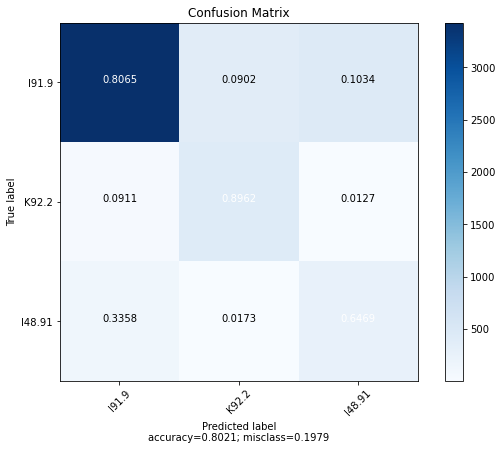

<Figure size 432x288 with 0 Axes>

In [20]:
plot_confusion_matrix(cm = np.array(confusion_matrix(y_t,y_hat)), 
                      normalize    = True,
                      target_names = ['I91.9','K92.2','I48.91'],
                      title        = "Confusion Matrix")
plt.savefig('../Reports/images/ConfMat_ternary_icd10.png') 

so, turning this into a ternary classification model really messes up the accuracy!  Let's see what'g going on here and see if we can improve. 

In [21]:
X = ter.TEXT.astype('str')
y = ter.icd10_code.astype('str')

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.25)

token_docs = [doc_preparer(doc, sw) for doc in X_train]
token_docs[10]

'admission date discharge date date birth sex service medicine allergy paxil haldol zyprexa risperdal ambien attend first name lf chief complaint ataxia anemia delirium major surgical invasive procedure intubation esophagogastroduodenoscopy history present illness h demyelinate disease nos question m seizure dementia nos question alzheimer initial namepattern last name namepattern body disease bipolar htn admit hospital facility unsteady gait neurology consult able speak pt facility cadbury common telephone fax much hpi derive note ed note per report pt sleep much past day restless night even prior admit pt stand dinner become dizzy look pale diaphoretic almost fell personnel report pt gait day admit lunch pt become dizzy bp pulse pulse increase pt walk briefly pt also report act like pt reportedly pleasant staff general name ni pt find ataxic exam cerebellar test unremarkable guaiac mildly positive slide vitals normal afebrile wbc slightly elevate hct decrease one year ago ua negative

In [22]:
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=42)

cv = CountVectorizer(max_df=500,max_features=1000)

X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,aaa,ab,abg,ablation,abscess,absent,abx,ac,accord,ace,...,wnl,word,wrist,wwp,xanthalesma,xanthomas,xray,xrt,yes,zofran
10983,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,1
12334,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16354,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,0,0
15704,0,0,0,0,0,1,0,0,0,0,...,3,0,0,0,0,0,0,5,0,2
871,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8832,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
15902,0,0,0,0,4,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13459,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
mnb.fit(X_t_vec, y_t)
prior_0 = y_t.value_counts()['I61.9']/len(y_t)
prior_1 = y_t.value_counts()['K92.2']/len(y_t)
prior_2 = y_t.value_counts()['I48.91']/len(y_t)

print(prior_0, prior_1, prior_2)
print(np.log(prior_1))

0.09211553473848556 0.07903981264637003 0.8288446526151444
-2.5378035959100855


In [24]:
y_hat = mnb.predict(X_t_vec)
print(accuracy_score(y_t, y_hat))
print(confusion_matrix(y_t,y_hat))

0.7634660421545667
[[3167  417  663]
 [  36  430    6]
 [  86    4  315]]


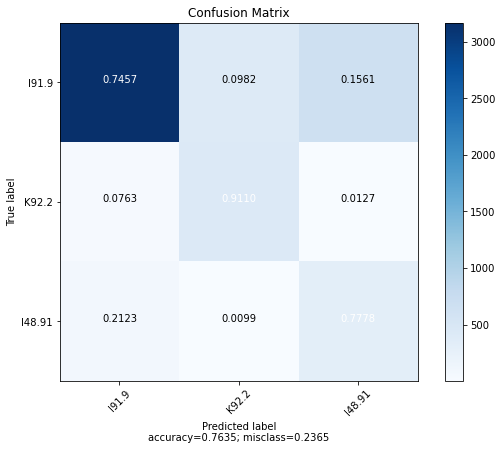

<Figure size 432x288 with 0 Axes>

In [25]:
plot_confusion_matrix(cm = np.array(confusion_matrix(y_t,y_hat)), 
                      normalize    = True,
                      target_names = ['I91.9','K92.2','I48.91'],
                      title        = "Confusion Matrix")
plt.savefig('../Reports/images/ConfMat_ternary_add_features.png') 

more features made this perform worse.  let's try a different vectorizer

In [26]:
tfidf = TfidfVectorizer(max_df=500,max_features=1000)

X_t_vec = tfidf.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,aaa,ab,abg,ablation,abscess,absent,abx,ac,accord,ace,...,wnl,word,wrist,wwp,xanthalesma,xanthomas,xray,xrt,yes,zofran
10983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.129629,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.068995
12334,0.000000,0.000000,0.000000,0.071655,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
16354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.080934,0.093112,0.0,0.000000
15704,0.000000,0.000000,0.000000,0.000000,0.000000,0.027403,0.000000,0.0,0.000000,0.00000,...,0.077248,0.0,0.0,0.0,0.0,0.0,0.000000,0.151241,0.0,0.055935
871,0.000000,0.000000,0.000000,0.000000,0.000000,0.148280,0.000000,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.02811,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
8832,0.000000,0.049927,0.000000,0.000000,0.042213,0.000000,0.000000,0.0,0.000000,0.00000,...,0.041034,0.0,0.0,0.0,0.0,0.0,0.041899,0.000000,0.0,0.000000
15902,0.000000,0.000000,0.000000,0.000000,0.264816,0.000000,0.316735,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
13459,0.096116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000


In [27]:
mnb.fit(X_t_vec, y_t)
prior_0 = y_t.value_counts()['I61.9']/len(y_t)
prior_1 = y_t.value_counts()['K92.2']/len(y_t)
prior_2 = y_t.value_counts()['I48.91']/len(y_t)

print(prior_0, prior_1, prior_2)
print(np.log(prior_1))

0.09211553473848556 0.07903981264637003 0.8288446526151444
-2.5378035959100855


In [28]:
y_hat = mnb.predict(X_t_vec)
print(accuracy_score(y_t, y_hat))
print(confusion_matrix(y_t,y_hat))

0.852263856362217
[[3863  312   72]
 [  73  398    1]
 [ 297    2  106]]


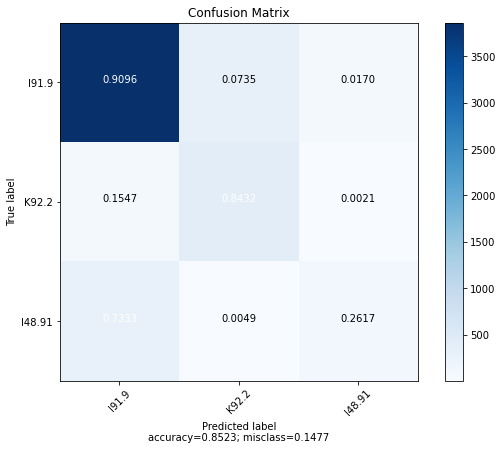

<Figure size 432x288 with 0 Axes>

In [29]:
plot_confusion_matrix(cm = np.array(confusion_matrix(y_t,y_hat)), 
                      normalize    = True,
                      target_names = ['I91.9','K92.2','I48.91'],
                      title        = "Confusion Matrix")
plt.savefig('../Reports/images/ConfMat_ternary_icd10_tfidf.png') 

the TF-IDF vectorizer did improve the model a bit, but let's see if we can understand why 